In [26]:
# Setup the Jupyter version of Dash
from jupyter_dash import JupyterDash

# Configure the necessary Python module imports
import dash_leaflet as dl
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output
import pandas as pd

# Add the necessary import
import plotly.graph_objs as go


# Import CRUD module
from CRUD import CRUD

# Configuration
username = "aacuser"
password = "testpass"
db_name = 'AAC'
collection_name = 'animals'
host = 'nv-desktop-services.apporto.com'
port = 32519

# Instantiate CRUD object
crud = CRUD(db_name, collection_name, username, password, host, port)

# Read data from MongoDB
data = crud.read({})

# Convert data to DataFrame
df = pd.DataFrame.from_records(data)
df.drop(columns=['_id'], inplace=True)

# Dashboard Layout
app = JupyterDash('SimpleExample')
app.layout = html.Div([
    html.Img(src="assets/logo.png", width="200", height="200"),
    html.Center(html.B(html.H1("Caio's awesome paginated dashboard with geolocation!"))),
    html.Div([
        html.Label("Rescue Type"),
        dcc.Dropdown(
            id='rescue-type-dropdown',
            options=[
                {'label': 'Water Rescue', 'value': 'water'},
                {'label': 'Mountain or Wilderness Rescue', 'value': 'mountainwild'},
                {'label': 'Disaster or Individual Tracking', 'value': 'disastertracking'},
                {'label': 'Reset Filters', 'value': 'reset'}
            ],
            value=[]
        ),
        html.Label("Preferred Dog Breeds"),
        dcc.Dropdown(
            id='dog-breed-dropdown',
            options=[
                {'label': 'All Breeds', 'value': ''},
                {'label': 'Pit Bull Mix', 'value': 'Pit Bull Mix'},
                {'label': 'Miniature Schnauzer Mix', 'value': 'Miniature Schnauzer Mix'},
                # Add more breeds as needed
            ],
            multi=True,  # Allow multiple selections
            value=[]  # No default selection
        ),
    ]),
    html.Hr(),
    dash_table.DataTable(
        id='datatable-id',
        columns=[
            {"name": i, "id": i, "deletable": False, "selectable": True} for i in df.columns
        ],
        data=df.to_dict('records'),
        row_selectable='single',  # Enable single-row selection
        page_action='native',  # Enable front-end pagination
        page_size=10,  # Set the number of rows per page
    ),
    html.Br(),
    html.Hr(),
        html.Div(
        [
            html.Div(
                id='map-id',
                className='six columns',  # Take up six columns of the available width (half)
                style={'width': '50%', 'height': '500px'}  # Set the width and height of the map
            ),
            html.Div(
                id='pie-chart',
                className='six columns',  # Take up six columns of the available width (half)
                style={'width': '50%', 'height': '800px'}  # Set the width and height of the pie chart
            ),
        ],
        className='row',
        style={'display': 'flex', 'flex-direction': 'row'}  # Apply flexbox styling
    ),
])

@app.callback(
    Output('datatable-id', 'data'),
    [Input('rescue-type-dropdown', 'value'),
     Input('dog-breed-dropdown', 'value')]
)
def update_table(rescue_type, dog_breeds):


    
    # Construct query based on selected criteria
    query = {}
    if rescue_type == "water":
        query['breed'] = {"$in": ["Labrador Retriever Mix", "Chesapeake Bay Retriever", "Newfoundland"]}
        query['sex_upon_outcome'] = "Intact Female"
        query['age_upon_outcome_in_weeks'] = {"$gte": 26, "$lte": 156}
    if rescue_type == "mountainwild":
        query['breed'] = {"$in": ["German Shepherd", "Alaskan Malamute", "Old English Sheepdog", "Siberian Husky", "Rottweiler"]}
        query['sex_upon_outcome'] = "Intact Male"
        query['age_upon_outcome_in_weeks'] = {"$gte": 26, "$lte": 156}
    elif rescue_type == "disastertracking":
        query['breed'] = {"$in": ["Doberman Pinscher", "German Shepherd", "Golden Retriever", "Bloodhound", "Rottweiler"]}
        query['sex_upon_outcome'] = "Intact Male"
        query['age_upon_outcome_in_weeks'] = {"$gte": 20, "$lte": 300}
    if dog_breeds:
        query['breed'] = {'$in': dog_breeds}
    
    # Fetch filtered data from MongoDB
    filtered_data = crud.read(query)
    
    print("filtered_data")
    print(filtered_data)
    
    df = pd.DataFrame.from_records(filtered_data)
    df.drop(columns=['_id'], inplace=True)

    # Return formatted data to update the data table
    return df.to_dict('records')


# Interaction Between Components
# Highlight selected row in the data table
@app.callback(
    Output('datatable-id', 'style_data_conditional'),
    [Input('datatable-id', 'selected_columns')]
)
def update_styles(selected_columns):
    #None check to avoid errors
    if selected_columns is None or len(selected_columns) == 0:
        return []

    return [{
        'if': {'column_id': i},
        'background_color': '#D2F3FF'
    } for i in selected_columns]


# Update the geolocation chart based on the selected row in the data table
@app.callback(
    Output('map-id', "children"),
    [Input('datatable-id', "derived_virtual_data"),
     Input('datatable-id', "derived_virtual_selected_rows")]
)
def update_map(viewData, index):
    #None check to avoid errors
    if viewData is None or len(viewData) == 0 or index is None or len(index) == 0:
        return dl.Map(style={'width': '1000px', 'height': '500px'},
                      center=[30.75, -97.48], zoom=10, children=[
                          dl.TileLayer(id="base-layer-id")
                      ])

    dff = pd.DataFrame.from_dict(viewData)
    row = index[0]

    # Create and return the geolocation chart with selected data
    return [
        dl.Map(style={'width': '1000px', 'height': '500px'},
               center=[30.75, -97.48], zoom=10, children=[
                   dl.TileLayer(id="base-layer-id"),
                   dl.Marker(position=[dff.iloc[row, 13], dff.iloc[row, 14]],
                             children=[
                                 dl.Tooltip(dff.iloc[row, 4]),
                                 dl.Popup([
                                     html.H1("Animal Name"),
                                     html.P(dff.iloc[row, 9])
                                 ])
                             ])
               ])
    ]

# Update the callback function for the pie chart
@app.callback(
    Output('pie-chart', 'children'),
    [Input('datatable-id', 'data')]
)
def update_pie_chart(data):
    print("Data received for pie chart:")
    print(data)
    
    if data is None:
        return html.Div("No data available")
    
    # Create a DataFrame from the filtered data
    df_filtered = pd.DataFrame.from_records(data)
    # Count the occurrences of each breed
    breed_counts = df_filtered['breed'].value_counts()
    
    print("Breed counts:")
    print(breed_counts)
    
    # Create a Plotly pie chart
    fig = go.Figure(data=[go.Pie(labels=breed_counts.index, values=breed_counts.values)])
    fig.update_layout(title='Split of Dog Breeds')
    
    # Return the Plotly pie chart as a dcc.Graph component
    return dcc.Graph(figure=fig)


update_pie_chart(data)

app.run_server(debug=True)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Breed counts:
Domestic Shorthair Mix                6016
Pit Bull Mix                          1602
Labrador Retriever Mix                1216
Chihuahua Shorthair Mix               1176
Domestic Medium Hair Mix               646
                                      ... 
Domestic Medium Hair/Maine Coon          2
Chinese Sharpei/Basset Hound             2
Staffordshire/Boston Terrier             2
Skye Terrier Mix                         2
Newfoundland/Australian Cattle Dog       2
Name: breed, Length: 817, dtype: int64
Dash app running on http://127.0.0.1:13480/


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



filtered_data
[{'_id': ObjectId('65f9b99d77b080892f98a42e'), 'rec_num': 5315, 'age_upon_outcome': '2 years', 'animal_id': 'A708726', 'animal_type': 'Dog', 'breed': 'Alaskan Malamute', 'color': 'Sable/White', 'date_of_birth': '2013-07-30', 'datetime': '2015-08-02 17:24:00', 'monthyear': '2015-08-02T17:24:00', 'name': 'Papa', 'outcome_subtype': '', 'outcome_type': 'Return to Owner', 'sex_upon_outcome': 'Intact Male', 'location_lat': 30.4309339291938, 'location_long': -97.480825836737, 'age_upon_outcome_in_weeks': 104.817857142857}, {'_id': ObjectId('65f9bdffc7d3893b31301758'), 'rec_num': 5315, 'age_upon_outcome': '2 years', 'animal_id': 'A708726', 'animal_type': 'Dog', 'breed': 'Alaskan Malamute', 'color': 'Sable/White', 'date_of_birth': '2013-07-30', 'datetime': '2015-08-02 17:24:00', 'monthyear': '2015-08-02T17:24:00', 'name': 'Papa', 'outcome_subtype': '', 'outcome_type': 'Return to Owner', 'sex_upon_outcome': 'Intact Male', 'location_lat': 30.4309339291938, 'location_long': -97.48082

Data received for pie chart:
[{'rec_num': 36, 'age_upon_outcome': '6 months', 'animal_id': 'A706953', 'animal_type': 'Dog', 'breed': 'Labrador Retriever Mix', 'color': 'Yellow', 'date_of_birth': '2014-12-06', 'datetime': '2015-07-06 11:33:00', 'monthyear': '2015-07-06T11:33:00', 'name': '', 'outcome_subtype': 'Medical', 'outcome_type': 'Euthanasia', 'sex_upon_outcome': 'Intact Female', 'location_lat': 30.5480802368633, 'location_long': -97.2969969058957, 'age_upon_outcome_in_weeks': 30.3544642857143}, {'rec_num': 732, 'age_upon_outcome': '2 years', 'animal_id': 'A749782', 'animal_type': 'Dog', 'breed': 'Labrador Retriever Mix', 'color': 'Tan/White', 'date_of_birth': '2015-05-19', 'datetime': '2017-07-25 14:59:00', 'monthyear': '2017-07-25T14:59:00', 'name': '*Catalina', 'outcome_subtype': '', 'outcome_type': 'Return to Owner', 'sex_upon_outcome': 'Intact Female', 'location_lat': 30.6138310636757, 'location_long': -97.5752164857665, 'age_upon_outcome_in_weeks': 114.089186507937}, {'rec_

filtered_data
[{'_id': ObjectId('65f9b99d77b080892f989e27'), 'rec_num': 3767, 'age_upon_outcome': '4 years', 'animal_id': 'A712291', 'animal_type': 'Dog', 'breed': 'Bloodhound', 'color': 'Red', 'date_of_birth': '2011-09-20', 'datetime': '2015-09-22 15:43:00', 'monthyear': '2015-09-22T15:43:00', 'name': 'Boomer', 'outcome_subtype': '', 'outcome_type': 'Return to Owner', 'sex_upon_outcome': 'Intact Male', 'location_lat': 30.2709983761287, 'location_long': -97.5923916912722, 'age_upon_outcome_in_weeks': 209.093551587302}, {'_id': ObjectId('65f9bdffc7d3893b31301159'), 'rec_num': 3767, 'age_upon_outcome': '4 years', 'animal_id': 'A712291', 'animal_type': 'Dog', 'breed': 'Bloodhound', 'color': 'Red', 'date_of_birth': '2011-09-20', 'datetime': '2015-09-22 15:43:00', 'monthyear': '2015-09-22T15:43:00', 'name': 'Boomer', 'outcome_subtype': '', 'outcome_type': 'Return to Owner', 'sex_upon_outcome': 'Intact Male', 'location_lat': 30.2709983761287, 'location_long': -97.5923916912722, 'age_upon_out

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



filtered_data
[{'_id': ObjectId('65f9b99d77b080892f988f74'), 'rec_num': 12, 'age_upon_outcome': '1 year', 'animal_id': 'A664843', 'animal_type': 'Dog', 'breed': 'Pit Bull Mix', 'color': 'Brown/White', 'date_of_birth': '2013-06-09', 'datetime': '2014-08-18 17:24:00', 'monthyear': '2014-08-18T17:24:00', 'name': 'Sherlock', 'outcome_subtype': 'Partner', 'outcome_type': 'Transfer', 'sex_upon_outcome': 'Neutered Male', 'location_lat': 30.4515549397366, 'location_long': -97.474104510925, 'age_upon_outcome_in_weeks': 62.2464285714286}, {'_id': ObjectId('65f9b99d77b080892f988f77'), 'rec_num': 15, 'age_upon_outcome': '3 years', 'animal_id': 'A712638', 'animal_type': 'Dog', 'breed': 'Pit Bull Mix', 'color': 'Red/White', 'date_of_birth': '2012-09-26', 'datetime': '2016-07-18 17:52:00', 'monthyear': '2016-07-18T17:52:00', 'name': 'Marcus', 'outcome_subtype': 'Partner', 'outcome_type': 'Transfer', 'sex_upon_outcome': 'Neutered Male', 'location_lat': 30.5798299207017, 'location_long': -97.5588487936

Data received for pie chart:
[{'rec_num': 12, 'age_upon_outcome': '1 year', 'animal_id': 'A664843', 'animal_type': 'Dog', 'breed': 'Pit Bull Mix', 'color': 'Brown/White', 'date_of_birth': '2013-06-09', 'datetime': '2014-08-18 17:24:00', 'monthyear': '2014-08-18T17:24:00', 'name': 'Sherlock', 'outcome_subtype': 'Partner', 'outcome_type': 'Transfer', 'sex_upon_outcome': 'Neutered Male', 'location_lat': 30.4515549397366, 'location_long': -97.474104510925, 'age_upon_outcome_in_weeks': 62.2464285714286}, {'rec_num': 15, 'age_upon_outcome': '3 years', 'animal_id': 'A712638', 'animal_type': 'Dog', 'breed': 'Pit Bull Mix', 'color': 'Red/White', 'date_of_birth': '2012-09-26', 'datetime': '2016-07-18 17:52:00', 'monthyear': '2016-07-18T17:52:00', 'name': 'Marcus', 'outcome_subtype': 'Partner', 'outcome_type': 'Transfer', 'sex_upon_outcome': 'Neutered Male', 'location_lat': 30.5798299207017, 'location_long': -97.5588487936533, 'age_upon_outcome_in_weeks': 198.820634920635}, {'rec_num': 17, 'age_u

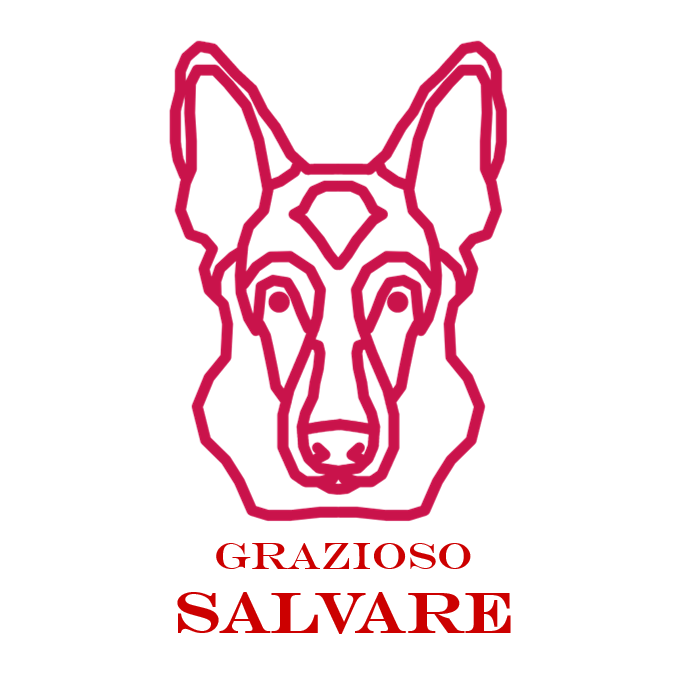